# Support Vector Machines

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randn, seed
from scipy.optimize import minimize
from sklearn.datasets import make_moons, make_biclusters
from matplotlib.colors import ListedColormap

%config InlineBackend.figure_format = "retina"

In [2]:
def plot_classf_model(X, y, model, ax, title=None, step=0.01, epsilon=0.1, contour=False):
    """
    Contourplot a two-class underlying model, and test datapoints.
    
    Paramters
    ---------
    X: Matrix(mxn, R)
        Matrix of feature vectors with examples
    y: n-dimensional vector 
        Actual classes for each of the "m" provided examples.
    """
    custom_cmap = ListedColormap(["#fafab0","#9898ff","#a0faa0"])
    points_cmap = ListedColormap(["Yellow", "Blue"])
    x0, x1 = X[:,0].min() - epsilon, X[:,0].max() + epsilon
    y0, y1 = X[:,1].min() - epsilon, X[:,1].max() + epsilon
    
    xx, yy = np.mgrid[x0:x1:step, y0:y1:step]
    
    preds = model.predict(np.c_[xx.ravel(), yy.ravel()])
    preds = preds.reshape(xx.shape)
    
    if contour:
        ax.contour(xx, yy, preds)
    ax.pcolormesh(xx, yy, preds, cmap=custom_cmap, shading="nearest")
    ax.scatter(*X.T, c=y, s=50, edgecolor="k", cmap=points_cmap)
    if title is not None:
        ax.set_title(title)


## Hard-Margin

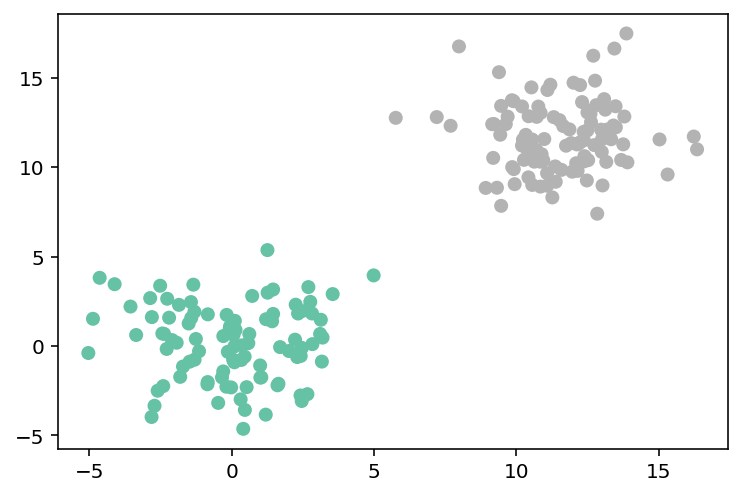

In [3]:
X, y, cols = make_biclusters((200, 2), 2, noise=2, random_state=1643)
y = y[0] * 2 - 1
plt.scatter(*X.T, c=y, cmap="Set2")

### Primal Problem
The SVM primal problem is given by

$$
\min_{\bf w} \frac{1}{2}||{\bf w}|^2 \\
s.t. \quad t_n({\bf w}^T{\bf x}_n + b) \geq 1 \quad \forall n\in\{1, \ldots, N\}
$$

In [4]:
def svm(w):
    w, b = w[:2], w[2]
    cost = (w.T @ w).item() / 2
    return cost

def constraint(w):
    w, b = w[:2], w[2]
    return y * (X @ w + b).ravel() - 1

N, M = X.shape
w0 = np.ones(M + 1)
w_star = minimize(svm, w0,
                  constraints={"fun":constraint, "type": "ineq"})
w_star.success

True

In [5]:
*w, b = w_star.x
w1, w2, b = w_star.x

x0, _ = X.min(axis=0)
x1, _ = X.max(axis=0)


y0 = -(x0 * w1 + b) / w2
y1 = -(x1 * w1 + b) / w2

ymin, ymax = min(y0, y1), max(y0, y1)

(-4.606807442967856, 20.011701499303356)

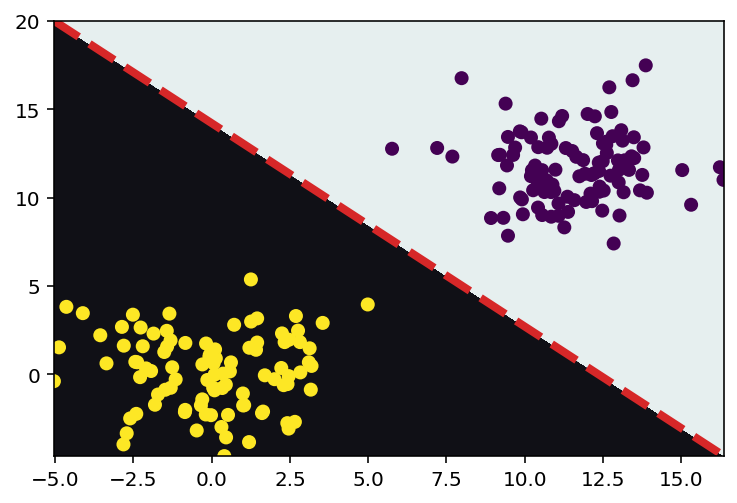

In [6]:
w = np.array(w)
mesh = np.mgrid[x0:x1:0.01, ymin:ymax:0.01]
xx, yy = mesh
_, k, k = mesh.shape
bias_mesh = np.ones((1, k, k))
Z = np.einsum("i,ijk->jk", w, mesh) + b >= 0

plt.contourf(xx, yy, Z, cmap="bone")
plt.scatter(*X.T, c=y, cmap="viridis_r")
plt.plot([x0, x1], [y0, y1], c="tab:red", linewidth=4, linestyle="dashed")
plt.xlim(x0, x1);
plt.ylim(ymin, ymax)

### Dual Problem

The SVM dual problem is given by


$$
\begin{align}
    \max_{{\boldsymbol \alpha}}&\sum_{n=1}^N\alpha_n - \frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N\alpha_n\alpha_m t_nt_m {\bf x}_n^T{\bf x}_m\\
    s.t.& \quad \alpha_n \geq 0 \forall n\in\{1,\ldots,N\}\\
        & \quad \sum_n \alpha_n t_n = 0
\end{align}
$$

In [7]:
from sklearn.svm import SVC

svm = SVC(C=np.inf, kernel="linear")
svm.fit(X, y)

SVC(C=inf, kernel='linear')

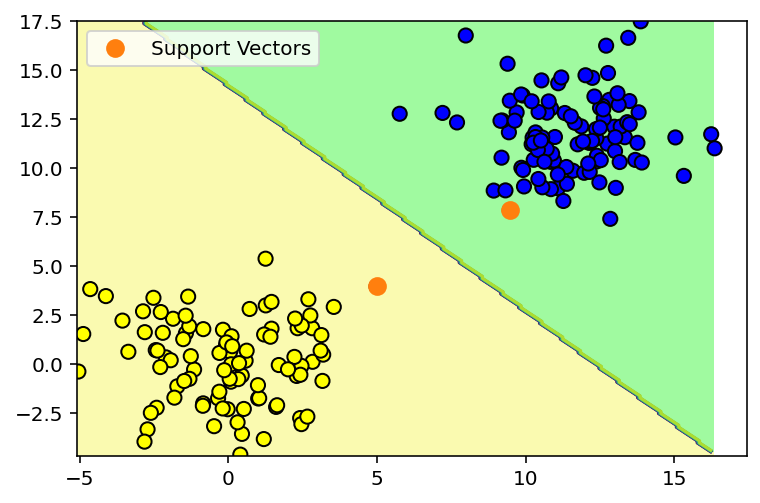

In [8]:
fig, ax = plt.subplots()
plot_classf_model(X, y, svm, ax, step=0.1, epsilon=0, contour=True)
plt.scatter(*svm.support_vectors_.T, c="tab:orange", label="Support Vectors", s=70)
plt.legend()

----
## Soft-Margin

### The non-separable case

If the database $\mathcal D$ is non-linearly separable, we relax the margin condition as follows

$$
\begin{align}
\min_{\bf w} & \frac{1}{2}||{\bf w}|^2 + C\sum_{n=1}^N \varepsilon_n\\
s.t. & \quad t_n({\bf w}^T{\bf x}_n + b) \geq 1 - \varepsilon_n \quad \forall n\in\{1, \ldots, N\}\\
& \quad \varepsilon_n \geq 0 \quad \forall n\in\{1, \ldots, N\}
\end{align}
$$

With dual problem given by

$$
\begin{align}
    \max_{{\boldsymbol \alpha}}&\sum_{n=1}^N\alpha_n - \frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N\alpha_n\alpha_m t_nt_m {\bf x}_n^T{\bf x}_m\\
    s.t.& \quad \alpha_n \in [0, C] \quad \forall n\in\{1,\ldots,N\}\\
        & \quad \sum_n \alpha_n t_n = 0
\end{align}
$$

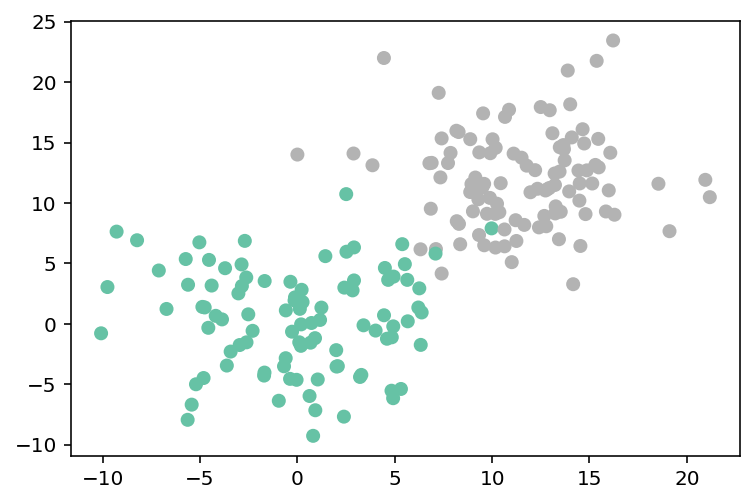

In [9]:
X, y, cols = make_biclusters((200, 2), 2, noise=4, random_state=1643)
y = y[0] * 2 - 1
plt.scatter(*X.T, c=y, cmap="Set2")

Example with three values of C and (soft margin) and a non-linearly-separable class

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/svm/_base.py:246: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


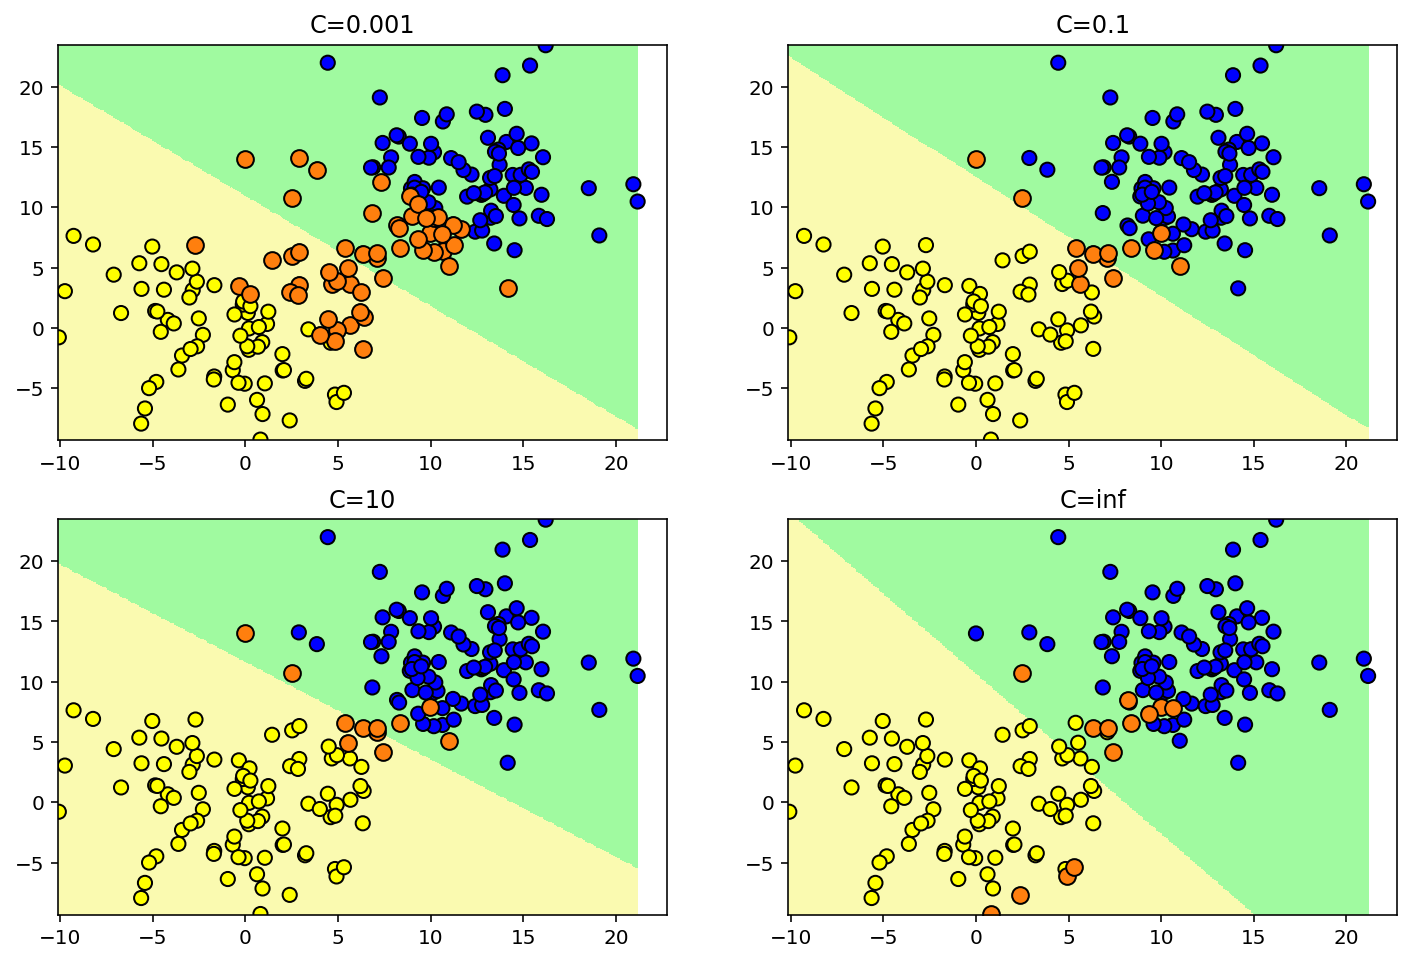

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()
C = [0.001, 0.1, 10, np.inf]

for axi, Ci in zip(ax, C):
    svm = SVC(C=Ci, kernel="linear", max_iter=1e5)
    svm.fit(X, y)

    plot_classf_model(X, y, svm, axi, step=0.1, epsilon=0)
    axi.scatter(*svm.support_vectors_.T, c="tab:orange", label="Support Vectors", s=70, edgecolor="black")
    axi.set_title(f"C={Ci}")

----
## Kernels 

$$
\begin{align}
    \max_{{\boldsymbol \alpha}}&\sum_{n=1}^N\alpha_n - \frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N\alpha_n\alpha_m t_nt_m K({\bf x}_n, {\bf x}_m)\\
    s.t.& \quad \alpha_n \in [0, C] \quad \forall n\in\{1,\ldots,N\}\\
        & \quad \sum_n \alpha_n t_n = 0
\end{align}
$$

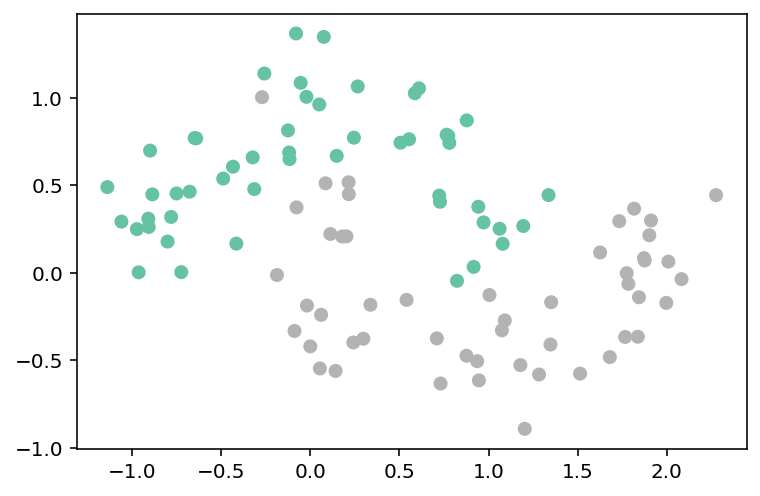

In [11]:
X, y = make_moons(100, noise=0.2, random_state=2718)
plt.scatter(*X.T, c=y, cmap="Set2")

In [12]:
from sklearn.model_selection import GridSearchCV

params = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10]
}

best_model = GridSearchCV(SVC(), params, n_jobs=-1, scoring="precision")

In [13]:
best_model.fit(X, y)
best_model.best_score_

1.0

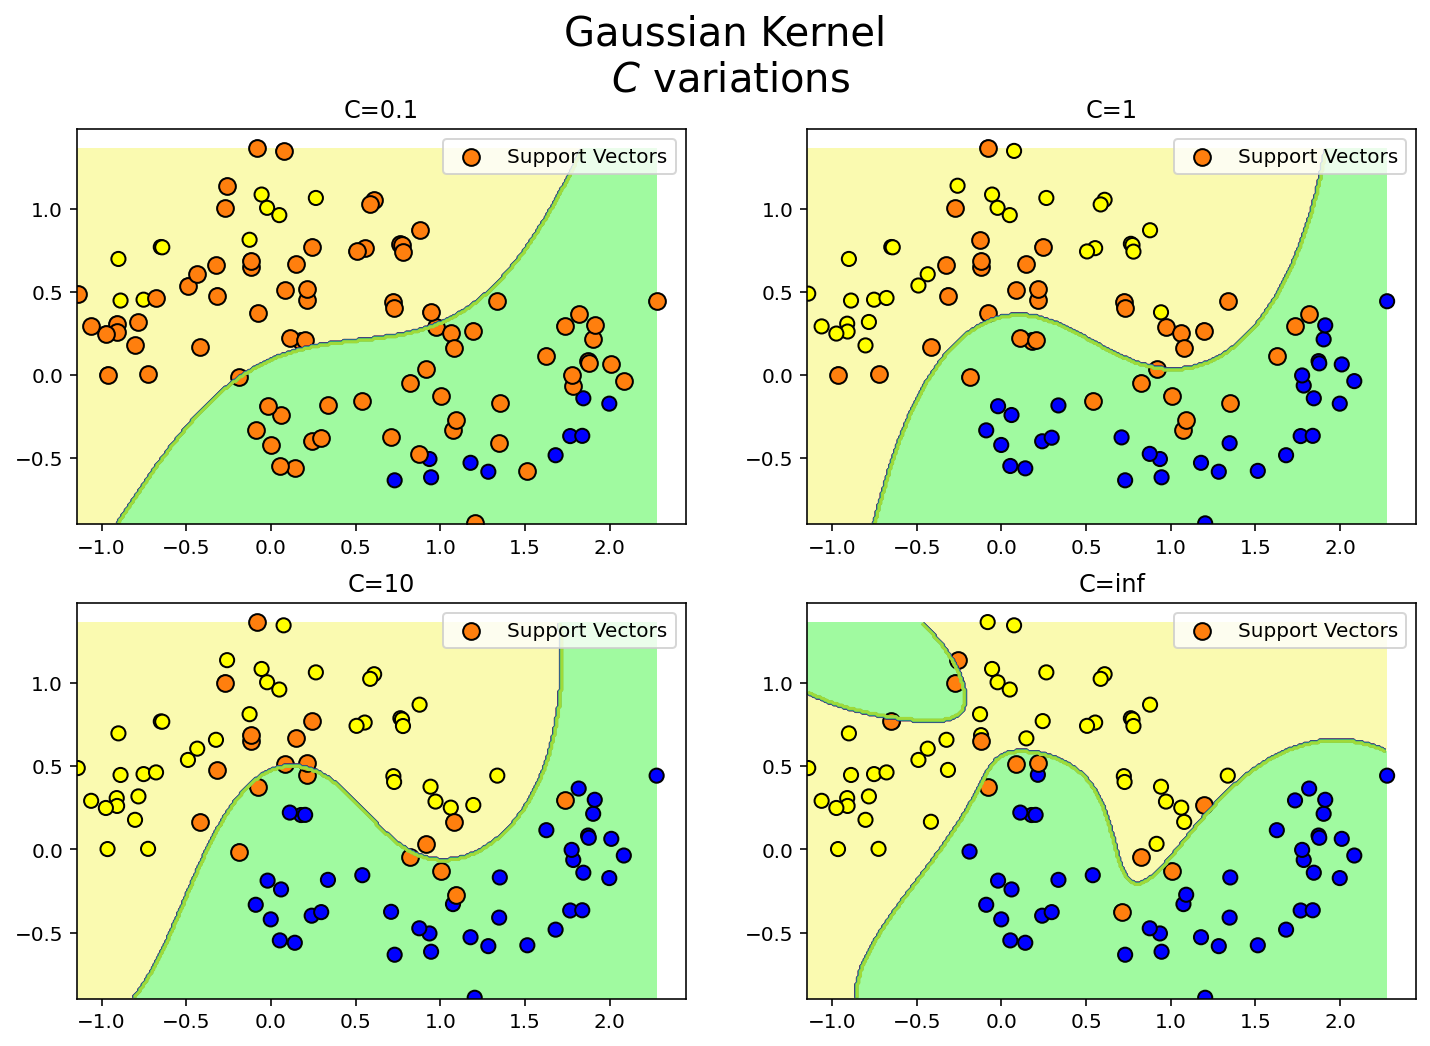

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()
C = [0.1, 1, 10, np.inf]

for axi, Ci in zip(ax, C):
    svm = SVC(C=Ci, kernel="rbf")
    svm.fit(X, y)    
    plot_classf_model(X, y, svm, axi, step=0.01, epsilon=0, contour=True)
    axi.scatter(*svm.support_vectors_.T, c="tab:orange", label="Support Vectors", s=70, edgecolor="black")
    axi.set_title(f"C={Ci}")
    axi.legend()
plt.suptitle("Gaussian Kernel\n $C$ variations", fontsize=20);

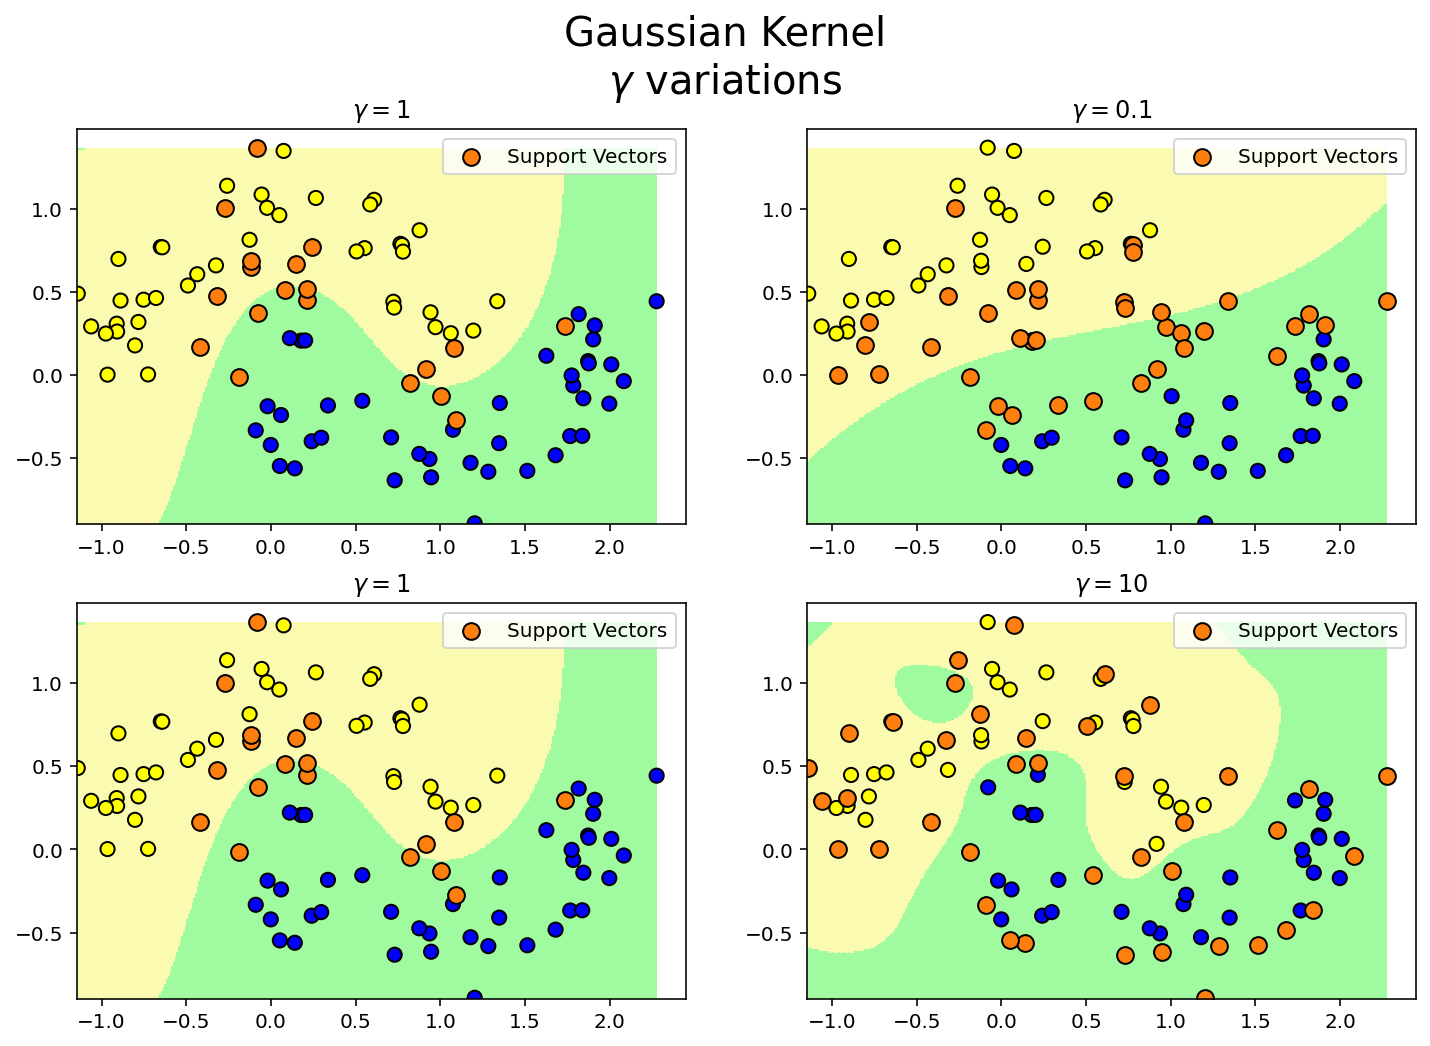

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

gamma = [1, 0.1, 1, 10]
Ci = 10
for axi, gamma_i in zip(ax, gamma):
    svm = SVC(C=Ci, kernel="rbf", gamma=gamma_i)
    svm.fit(X, y)    
    plot_classf_model(X, y, svm, axi, step=0.01, epsilon=0)
    axi.scatter(*svm.support_vectors_.T, c="tab:orange", label="Support Vectors", s=70, edgecolor="black")
    axi.set_title(f"$\gamma={gamma_i}$")
    axi.legend()
plt.suptitle("Gaussian Kernel\n$\gamma$ variations", fontsize=20);

### Testing different kernels

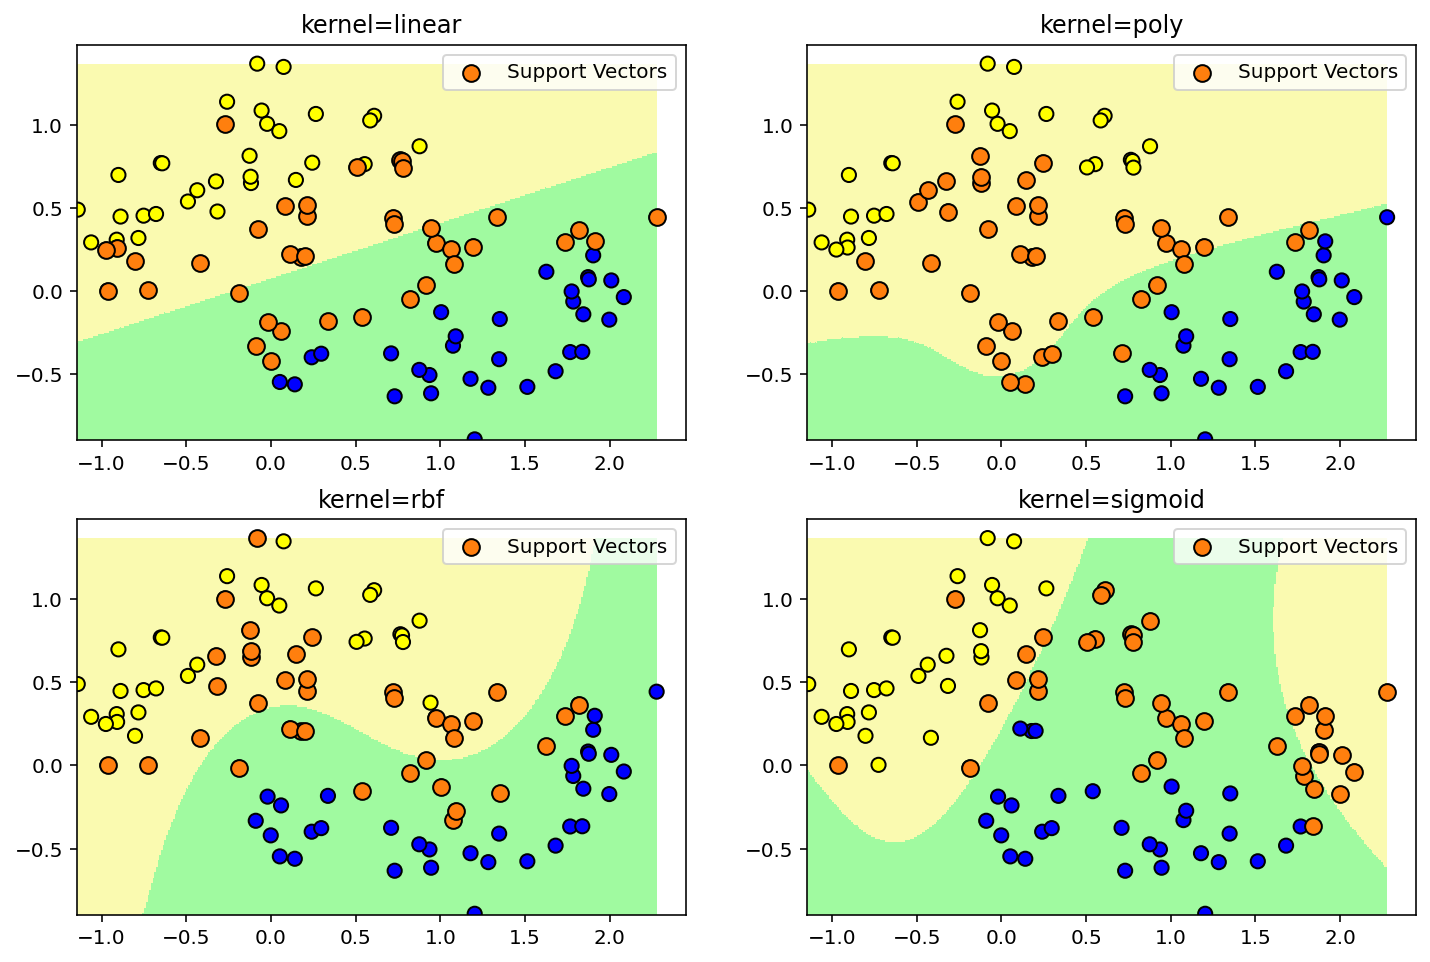

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()

kernels = ["linear", "poly", "rbf", "sigmoid"]

for axi, kernel in zip(ax, kernels):
    svm = SVC(C=1, kernel=kernel, max_iter=1000)
    svm.fit(X, y)    
    plot_classf_model(X, y, svm, axi, step=0.01, epsilon=0)
    axi.scatter(*svm.support_vectors_.T, c="tab:orange", label="Support Vectors", s=70, edgecolor="black")
    axi.set_title(f"kernel={kernel}")
    axi.legend()

## Regression Support Vector Machine

$$
\begin{aligned}
&\min_{\bf w, b} C\sum(\varepsilon_n^+ + \varepsilon_n^- ) + \frac{1}{2}||{\bf w}||^2\\
s.t.& \quad t_n \leq ({\bf w}^T{\bf x}_n + b) + \epsilon + \varepsilon_n^+ \quad \forall n\in\{1, \ldots, N\} \\
 &\quad t_n \geq ({\bf w}^T{\bf x}_n + b) - \epsilon - \varepsilon_n^- \quad \forall n\in\{1, \ldots, N\} \\
 &\varepsilon_n^+ \geq 0 \quad \forall n\in\{1, \ldots, N\}\\
 &\varepsilon_n^- \geq 0 \quad \forall n\in\{1, \ldots, N\}\\
\end{aligned}
$$

In [17]:
from sklearn.svm import SVR

In [18]:
from numpy.random import randn, seed, uniform, shuffle
seed(314)
nsamp = 120
x = np.linspace(-3, 3, nsamp) + uniform(-1, 1, size=nsamp)
y = x ** 2 + randn(nsamp)

D = np.c_[x, y]
seed(314)
shuffle(D)

x, y = D.T
x, x_test = x[:-20, np.newaxis], x[-20:, np.newaxis]
y, y_test = y[:-20], y[-20:]

In [19]:
from ipywidgets import interact, FloatSlider, Dropdown, IntSlider

@interact(epsilon=FloatSlider(min=0.1, max=3.1, step=0.1),
          C=FloatSlider(min=1, max=100, step=10),
          kernel=Dropdown(options=["rbf", "poly"]),
          deg=IntSlider(min=1, max=5, step=1))
def plot_svr(epsilon, C, kernel, deg, ax=False):
    ax = plt.subplot() if ax is False else ax
    svm = SVR(epsilon=epsilon, C=C, kernel=kernel, degree=deg)
    svm.fit(x, y)

    xrange = np.linspace(x.min(), x.max(), 200)[:, np.newaxis]
    yhat = svm.predict(xrange)

    ax.scatter(x, y)
    ax.scatter(svm.support_vectors_, y[svm.support_])
    ax.plot(xrange, yhat, c="tab:orange", linewidth=4)

interactive(children=(FloatSlider(value=0.1, description='epsilon', max=3.1, min=0.1), FloatSlider(value=1.0, …

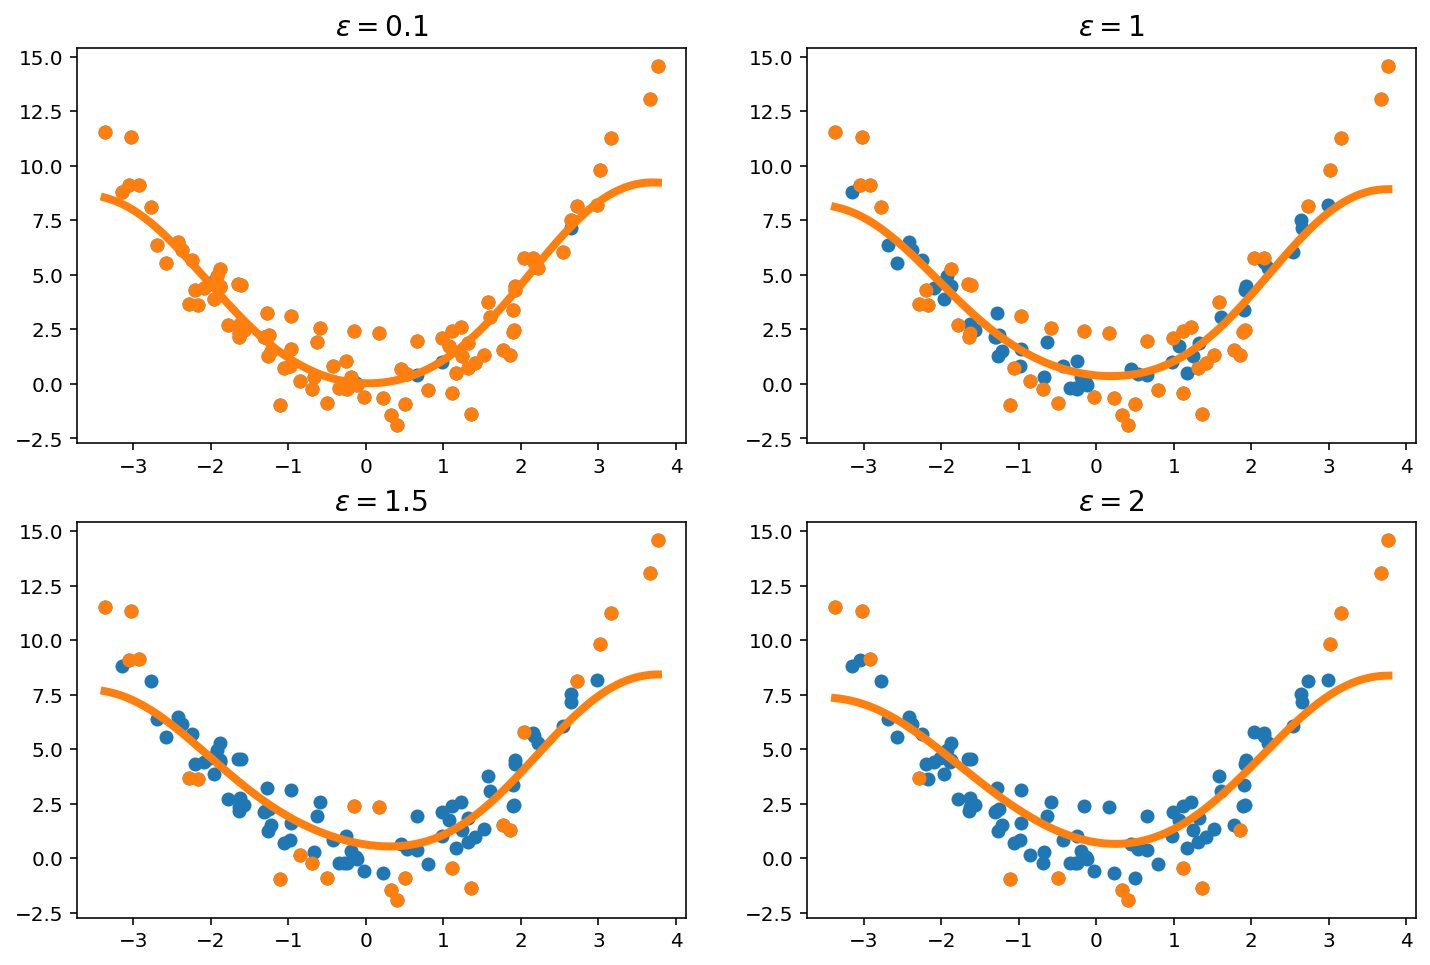

In [20]:
C, kernel, deg= 1, "rbf", 1
eps_values = [0.1, 1, 1.5, 2]

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.ravel()
for axi, eps in zip(ax, eps_values):
    axi.set_title(r"$\epsilon=$" f"{eps}", fontsize=14)
    plot_svr(eps, C, kernel, deg, axi)